# Overview

This task involves experimenting with additional Ranker features and seeing whether their inclusion results in improvements in our metrics. See https://wiki.it9.org/display/DS/Ranker+Features for a list of potential new features.

## Solution Length
This is a query-independent feature. For each query-solution pair, there will be an additional feature for the length of the solution. Technically, there will be a couple features for the solution length, as it gets binned. Currently, it's just using the raw solution length, but we'll want to try out other transformations as well, like using the log of hte solution length.

Populating the interactive namespace from numpy and matplotlib


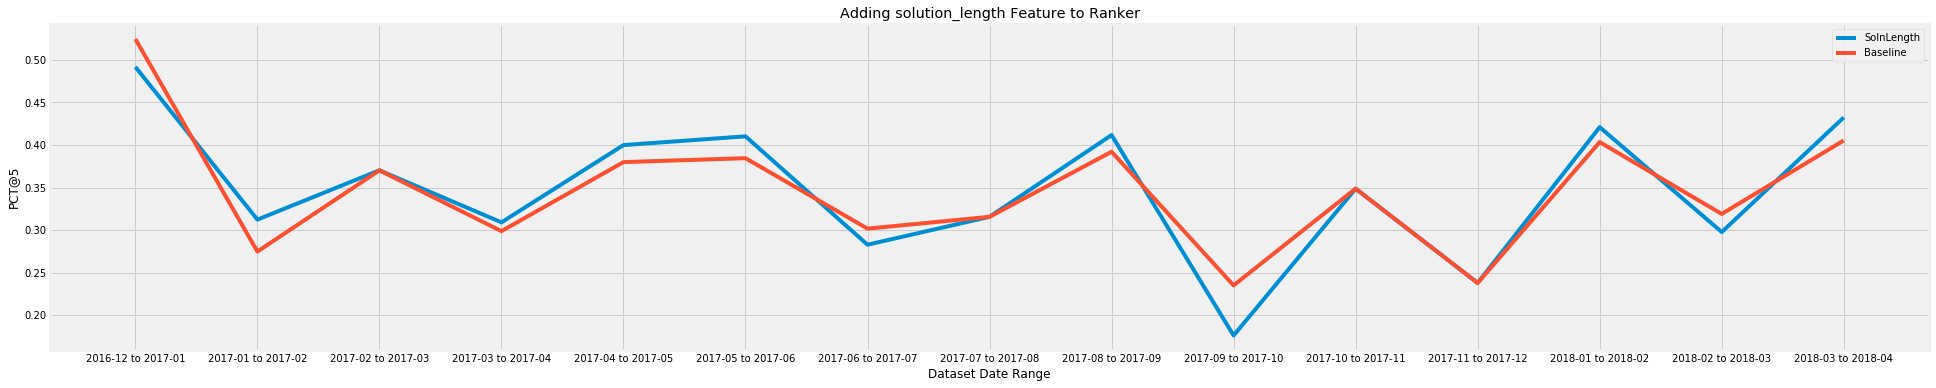

In [1]:
dates = ["2016-12 to 2017-01", "2017-01 to 2017-02", "2017-02 to 2017-03", "2017-03 to 2017-04", "2017-04 to 2017-05",
         "2017-05 to 2017-06", "2017-06 to 2017-07", "2017-07 to 2017-08", "2017-08 to 2017-09", "2017-09 to 2017-10",
         "2017-10 to 2017-11", "2017-11 to 2017-12", "2018-01 to 2018-02", "2018-02 to 2018-03", "2018-03 to 2018-04"]

solution_length_metrics = [0.491803, 0.3125, 0.37037, 0.309278, 0.4,
                           0.410256, 0.283019, 0.315789, 0.411765, 0.176471,
                           0.348837, 0.238095, 0.421053, 0.297872, 0.432432]

baseline_metrics = [0.52459, 0.275, 0.37037, 0.298969, 0.38,
                    0.384615, 0.301887, 0.315789, 0.392157, 0.235294,
                    0.348837, 0.238095, 0.403509, 0.319149, 0.405405]


%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%pylab inline
pylab.rcParams['figure.figsize'] = (30, 6)

plt.plot(dates, solution_length_metrics, label="SolnLength")
plt.plot(dates, baseline_metrics, label="Baseline")
plt.ylabel("PCT@5")
plt.xlabel("Dataset Date Range")
plt.title("Adding solution_length Feature to Ranker")
plt.legend()
plt.show()

In [70]:
from datetime import datetime, timedelta
import os

from common.helper import get_collection, create_collection
from common.models import RankingModel

from experiments.link_cohesion import save_cohesion

In [107]:
MODEL_NAME = 'vSphere 6.5'
MODEL_ID = 47
QUERY_FQ = "+doc_type:question +(division_names_Ft:''vSphere 6.5'' domain:''VMware vCenter Server Appliance 6.5'' domain:''VMware vCenter Server 6.5'' domain:''VMware Update Manager 6.5'' domain:''VMware vSphere ESXi 6.5'')"
SIMILAR_QUERY_FQ = "+doc_type:question +(division_names_Ft:''vSphere 6.5'' domain:''VMware vCenter Server Appliance 6.5'' domain:''VMware vCenter Server 6.5'' domain:''VMware Update Manager 6.5'' domain:''VMware vSphere ESXi 6.5'')"

# STARTING_DATE = datetime.strptime("2018-04-23T00:00:00Z", "%Y-%m-%dT%H:%M:%SZ")
# LAST_DATE = datetime.strptime("2018-10-31T00:00:00Z", "%Y-%m-%dT%H:%M:%SZ")

STARTING_DATE = datetime.strptime("2018-04-01T00:00:00Z", "%Y-%m-%dT%H:%M:%SZ")
LAST_DATE = datetime.strptime("2018-10-31T00:00:00Z", "%Y-%m-%dT%H:%M:%SZ")

def get_sql_statement(date_range):
    modified_query_fq = ('{} {}').format(date_range, QUERY_FQ)
    modified_similar_query_fq = ('{} {}').format(date_range, SIMILAR_QUERY_FQ)
    return "UPDATE ranking_model SET query_fq = '{}', similar_query_fq = '{}' WHERE name = '{}'".format(modified_query_fq, modified_similar_query_fq, MODEL_NAME)


def get_date_ranges(starting_date, initial_delta_days, total_num, day_delta, last_date):
    initial_delta = timedelta(days=initial_delta_days)
    window_delta = timedelta(days=day_delta)
    d = starting_date + initial_delta
    for _ in range(total_num):
        if d < last_date:
            yield "+date:[{} TO {}]".format(datetime.strftime(starting_date, "%Y-%m-%dT%H:%M:%SZ"),
                                            datetime.strftime(d, "%Y-%m-%dT%H:%M:%SZ"))
        else:
            break
        d = d + window_delta

In [108]:
list(get_date_ranges(STARTING_DATE, initial_delta, num_iterations, window_delta, LAST_DATE))

['+date:[2018-04-01T00:00:00Z TO 2018-05-13T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-05-27T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-06-10T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-06-24T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-07-08T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-07-22T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-08-05T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-08-19T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-09-02T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-09-16T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-09-30T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-10-14T00:00:00Z]',
 '+date:[2018-04-01T00:00:00Z TO 2018-10-28T00:00:00Z]']

In [114]:
from IPython.display import clear_output

collections = {}
output_file_name = "RankerOutput.txt"
num_iterations = 50
initial_delta = 42
window_delta = 14

total_iterations = len(list(get_date_ranges(STARTING_DATE, initial_delta, num_iterations, window_delta, LAST_DATE)))
current_iteration = 1
 
for date_range in get_date_ranges(STARTING_DATE, initial_delta, num_iterations, window_delta, LAST_DATE):
    print("------------------------------------------------------")
    print("Running experiment with date range {}".format(date_range))
    command = 'psql -h postgres -d its_ranker -U postgres -c "{}"'.format(get_sql_statement(date_range))
    !{command}
    
    ranking_model = RankingModel.get(RankingModel.id == MODEL_ID)
    corpus = ranking_model.corpus
    collection_name = "Baseline: {}".format(date_range)
    create_collection(corpus.name, ranking_model.name, collection_name)
    
#     clear_output()
#     print("Computing and updating solution statistics for {}/{}...".format(current_iteration, total_iterations))
#     start_date = date_range.split("[")[1].split("T00")[0]
#     end_date = date_range.split(" TO ")[1].split("]")[0]
#     %cd /ranker/scripts
#     !{'./agg.sh agg --start-date {} --end-date {}'.format(start_date, end_date)}
    
#     clear_output()
#     print("Computing linked doc cohesion for {}/{}...".format(current_iteration, total_iterations))
#     save_cohesion(datetime.strftime(STARTING_DATE, "%Y-%m-%dT%H:%M:%SZ"), 
#                   end_date)
    
    clear_output()
    print("Ranker currently in progress for {}/{}...".format(current_iteration, total_iterations))
    %cd /ranker/src/train
    !{'python ranker_driver.py "{}" "{}"'.format(corpus.name, ranking_model.name)}
    collections[collection_name] = get_collection(ranking_model)
    print("Ranker completed. PCT@5: {}".format(collections[collection_name].pct_at_n[4]))
#     !{'rm {}'.format(output_file_name)}
    
#     clear_output()
#     print("Reseting solution statistics for {}/{}...".format(current_iteration, total_iterations))
#     %cd /ranker/scripts
#     !{'./agg.sh clear'}
    
    clear_output()
    print("Completed {}/{}".format(current_iteration, total_iterations))
    current_iteration += 1

Completed 13/13


In [37]:
import psycopg2

conn = psycopg2.connect("dbname='its_ranker' user='postgres' host='postgres' password=''")

In [120]:
def get_pct5s(name, n, model_id, dates):
    cur = conn.cursor()
    cur.execute("SELECT id, name, pct_at_n FROM collection WHERE ranking_model_id = {} ORDER BY id DESC".format(model_id))
    psql_results = {}
    for resp in cur:
        psql_results[resp[1]] = resp[2]

    pct5s = []
    for date_range in dates[:n]:
        key = "{}: {}".format(name, date_range)
        pct5s.append(psql_results[key][4])
    return pct5s

In [126]:
vsphere_5_5_dates = list(get_date_ranges(datetime.strptime("2016-01-01T00:00:00Z", "%Y-%m-%dT%H:%M:%SZ"), initial_delta, num_iterations, window_delta, LAST_DATE))
linked_cohesion_pct5s = get_pct5s("LinkedCohesion", 50, 43, vsphere_5_5_dates)
baseline_pct5s = get_pct5s("Baseline", 50, 43, vsphere_5_5_dates)
solution_length_pct5s = get_pct5s("SolnLen", 50, 43, vsphere_5_5_dates)
solution_log_length_pct5s = get_pct5s("LogSolnLen", 50, 43, vsphere_5_5_dates)
solution_assigned_domains_pct5s = get_pct5s("SolnAssignedDomains", 50, 43, vsphere_5_5_dates)

vsphere_6_5_dates = list(get_date_ranges(STARTING_DATE, initial_delta, num_iterations, window_delta, LAST_DATE))
solution_stats_pct5s = get_pct5s("SolutionStats", 13, 47, vsphere_6_5_dates)
vsphere6_5_baseline_pct5s = get_pct5s("Baseline", 13, 47, vsphere_6_5_dates)

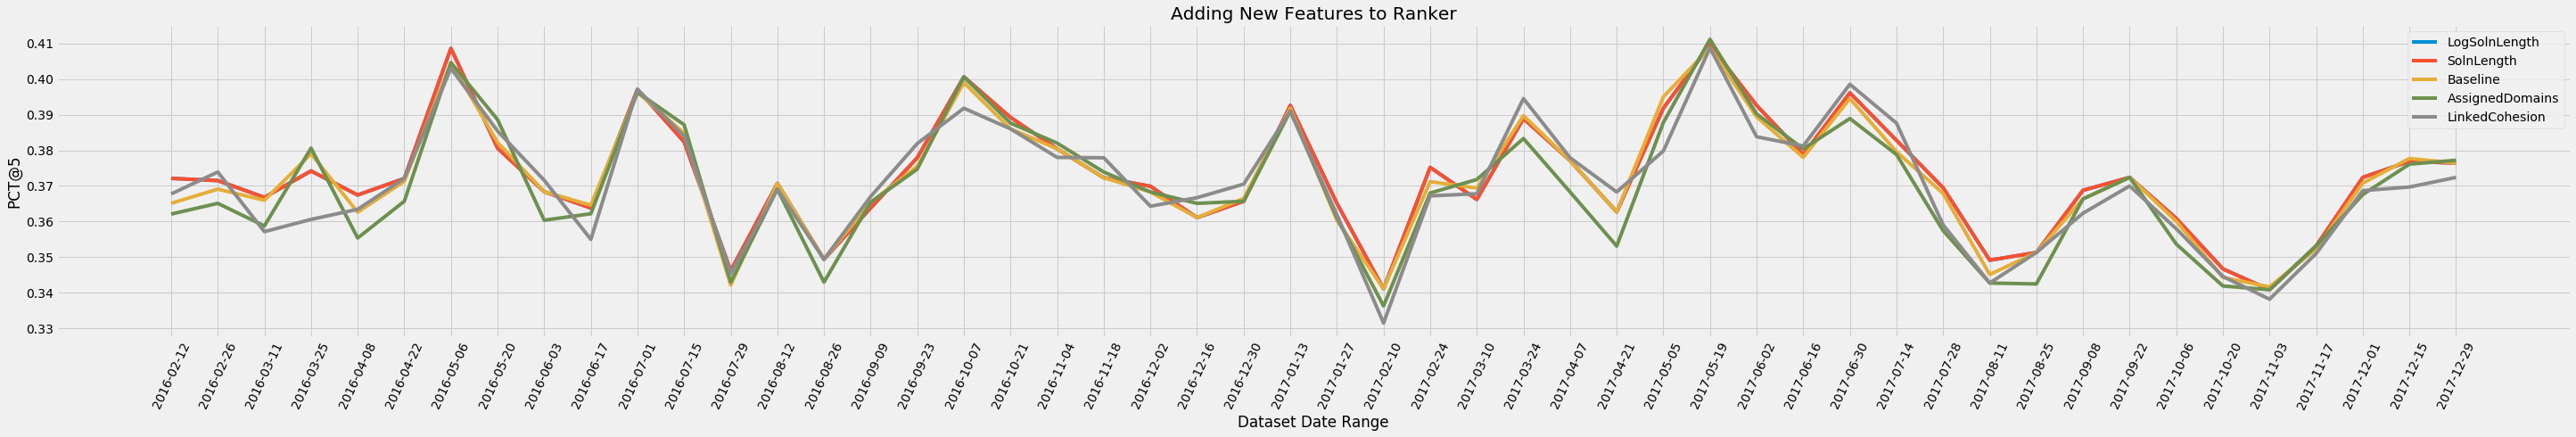

In [103]:
plt.style.use('fivethirtyeight')
pylab.rcParams['figure.figsize'] = (45, 6)

dates = [d.split("TO ")[1].split("T")[0] for d in get_date_ranges(STARTING_DATE, initial_delta, num_iterations, window_delta, LAST_DATE)]

plt.plot(dates, solution_log_length_pct5s, label="LogSolnLength")
plt.plot(dates, solution_length_pct5s, label="SolnLength")
plt.plot(dates, baseline_pct5s, label="Baseline")
plt.plot(dates, solution_assigned_domains_pct5s, label="AssignedDomains")
plt.plot(dates, linked_cohesion_pct5s, label="LinkedCohesion")
plt.ylabel("PCT@5")
plt.xlabel("Dataset Date Range")
plt.title("Adding New Features to Ranker")
plt.xticks(fontsize=14, rotation=65)
# plt.ylim(0.17, 0.55)
plt.legend()
plt.show()

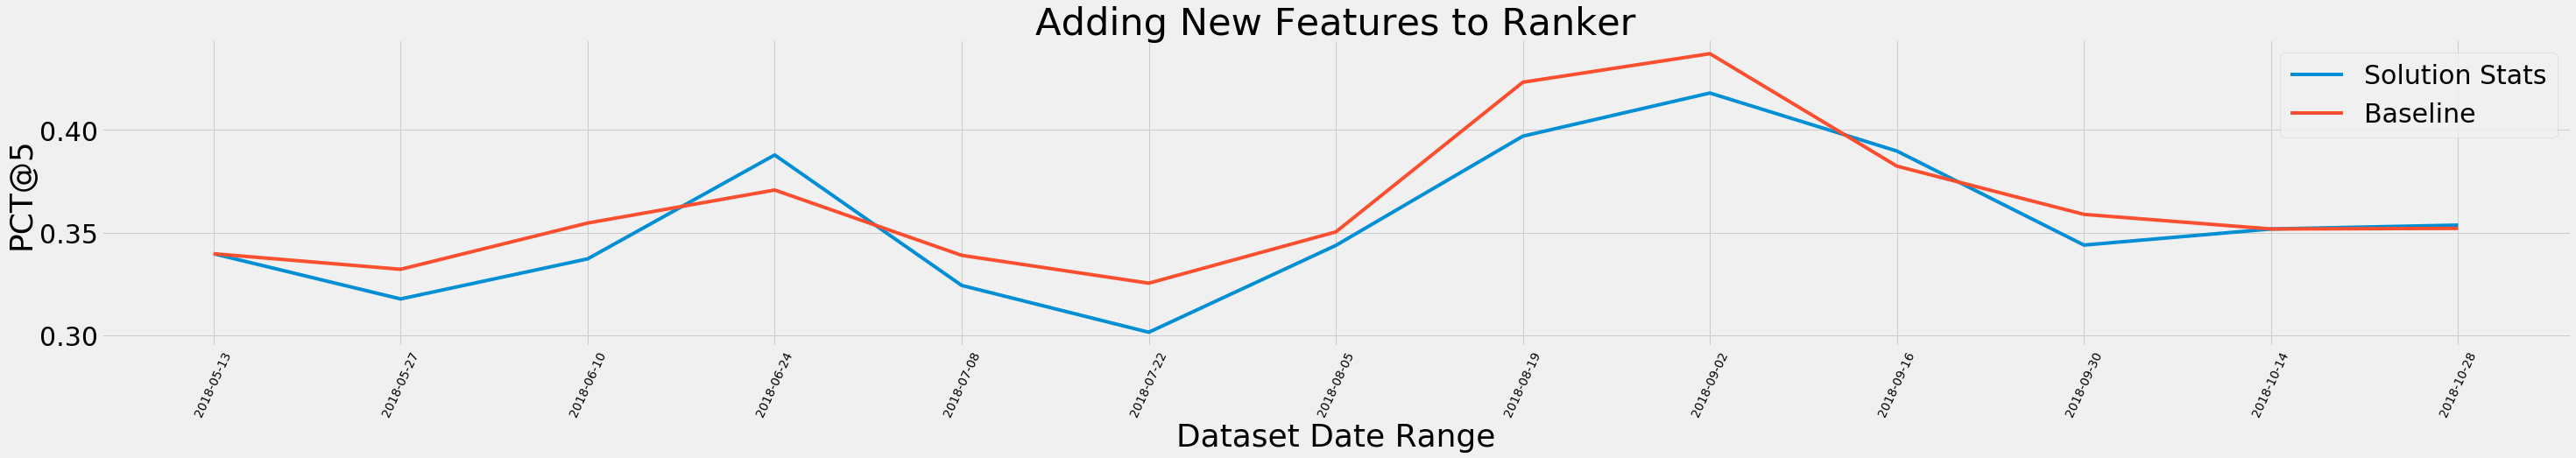

In [127]:
dates = [d.split("TO ")[1].split("T")[0] for d in get_date_ranges(STARTING_DATE, initial_delta, num_iterations, window_delta, LAST_DATE)]

plt.plot(dates, solution_stats_pct5s, label="Solution Stats")
plt.plot(dates, vsphere6_5_baseline_pct5s, label="Baseline")
plt.ylabel("PCT@5")
plt.xlabel("Dataset Date Range")
plt.title("Adding New Features to Ranker")
plt.xticks(fontsize=14, rotation=65)
# plt.ylim(0.17, 0.55)
plt.legend()
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%pylab inline
pylab.rcParams['figure.figsize'] = (45, 6)

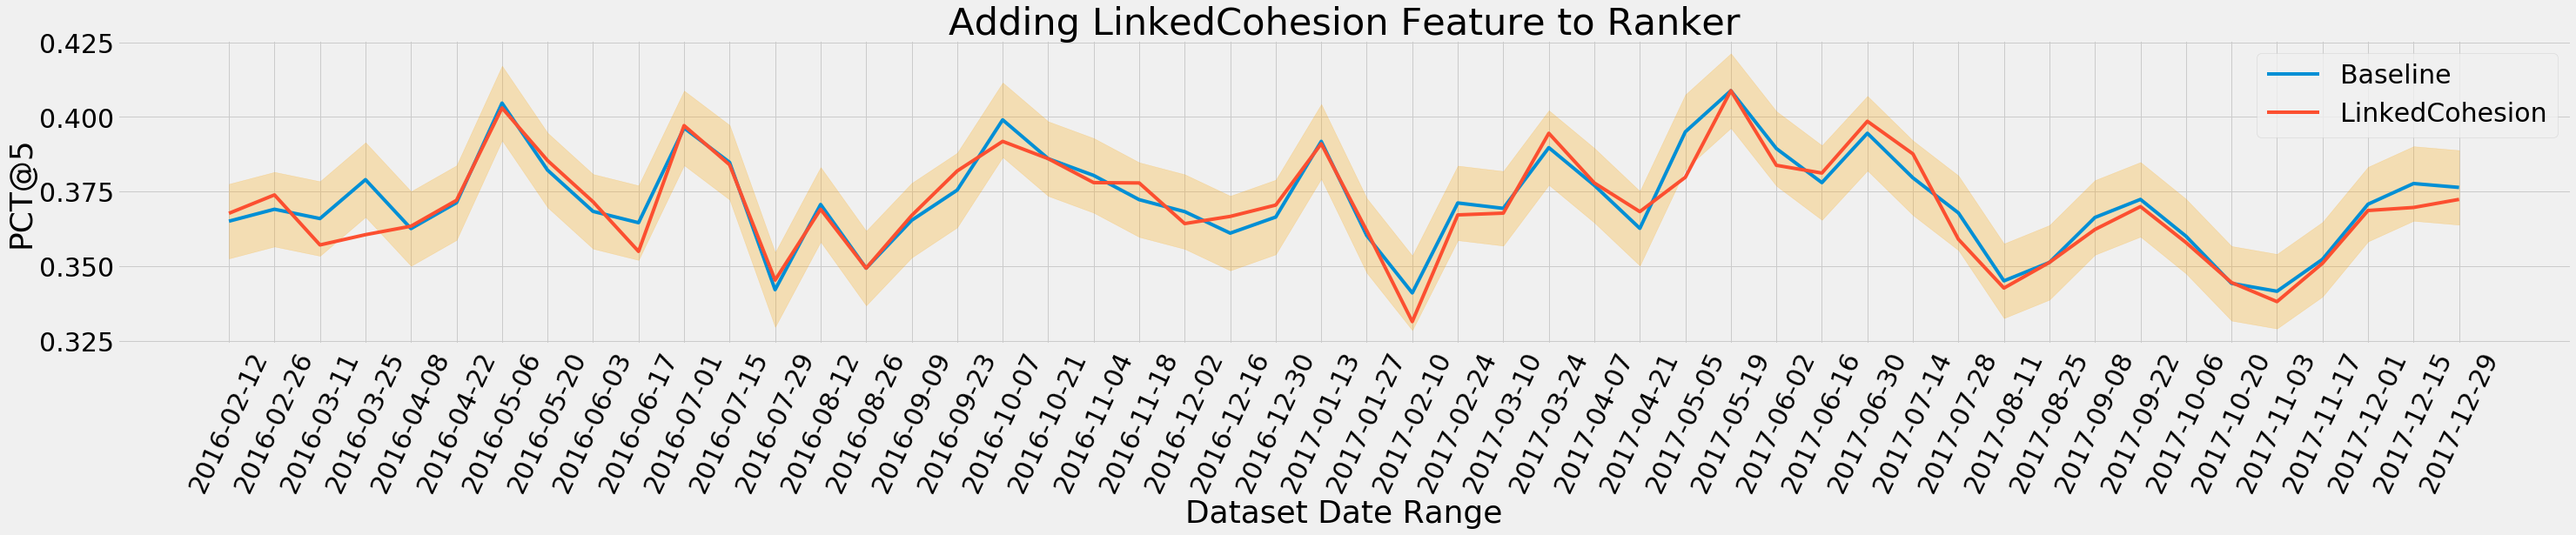

In [105]:
plt.rcParams.update({'font.size': 30})

plt.plot(dates, baseline_pct5s, label="Baseline")
plt.plot(dates, linked_cohesion_pct5s, label="LinkedCohesion")
plt.ylabel("PCT@5")
plt.xlabel("Dataset Date Range")
plt.title("Adding LinkedCohesion Feature to Ranker")
plt.xticks(rotation=65)


baseline_error = get_error(baseline_pct5s, 1500)
plt.fill_between(range(len(dates)), 
                 [val + baseline_error for val in baseline_pct5s], 
                 [val - baseline_error for val in baseline_pct5s], color='orange', alpha=.25)
plt.legend()
plt.show()

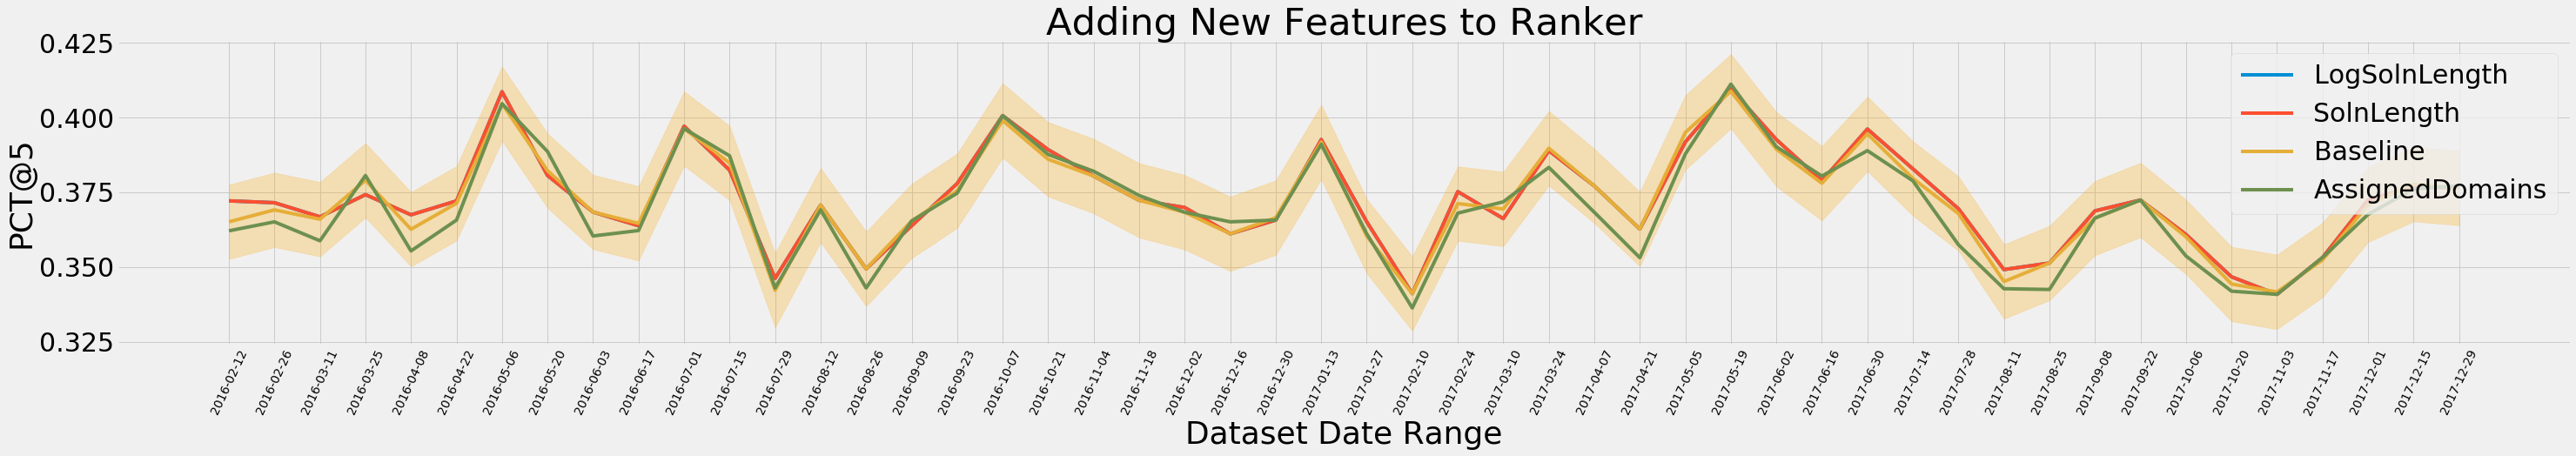

In [97]:
plt.plot(dates, solution_log_length_pct5s, label="LogSolnLength")
plt.plot(dates, solution_length_pct5s, label="SolnLength")
plt.plot(dates, baseline_pct5s, label="Baseline")
plt.plot(dates, solution_assigned_domains_pct5s, label="AssignedDomains")
plt.ylabel("PCT@5")
plt.xlabel("Dataset Date Range")
plt.title("Adding New Features to Ranker")
plt.xticks(fontsize=14, rotation=65)


baseline_error = get_error(baseline_pct5s, 1500)
plt.fill_between(range(len(dates)), 
                 [val + baseline_error for val in baseline_pct5s], 
                 [val - baseline_error for val in baseline_pct5s], color='orange', alpha=.25)
plt.legend()
plt.show()

In [49]:
import numpy as np

def get_error(values, num_queries):
    mean = np.mean(values)
    return np.sqrt(mean * (1 - mean) / num_queries)

plt.plot(dates, solution_log_length_pct5s, label="LogSolnLength")
plt.plot(dates, solution_length_pct5s, label="SolnLength")
plt.plot(dates, baseline_pct5s, label="Baseline")
plt.plot(dates, solution_assigned_domains_pct5s, label="AssignedDomains")
plt.ylabel("PCT@5")
plt.xlabel("Dataset Date Range")
plt.title("Adding Assigned Domains Feature to Ranker")
plt.xticks(fontsize=14, rotation=65)


baseline_error = get_error(baseline_pct5s, 1500)
plt.fill_between(range(len(dates)), 
                 [val + baseline_error for val in baseline_pct5s], 
                 [val - baseline_error for val in baseline_pct5s], color='orange', alpha=.25)
plt.legend()
plt.show()

NameError: name 'logsolnlength_collections' is not defined

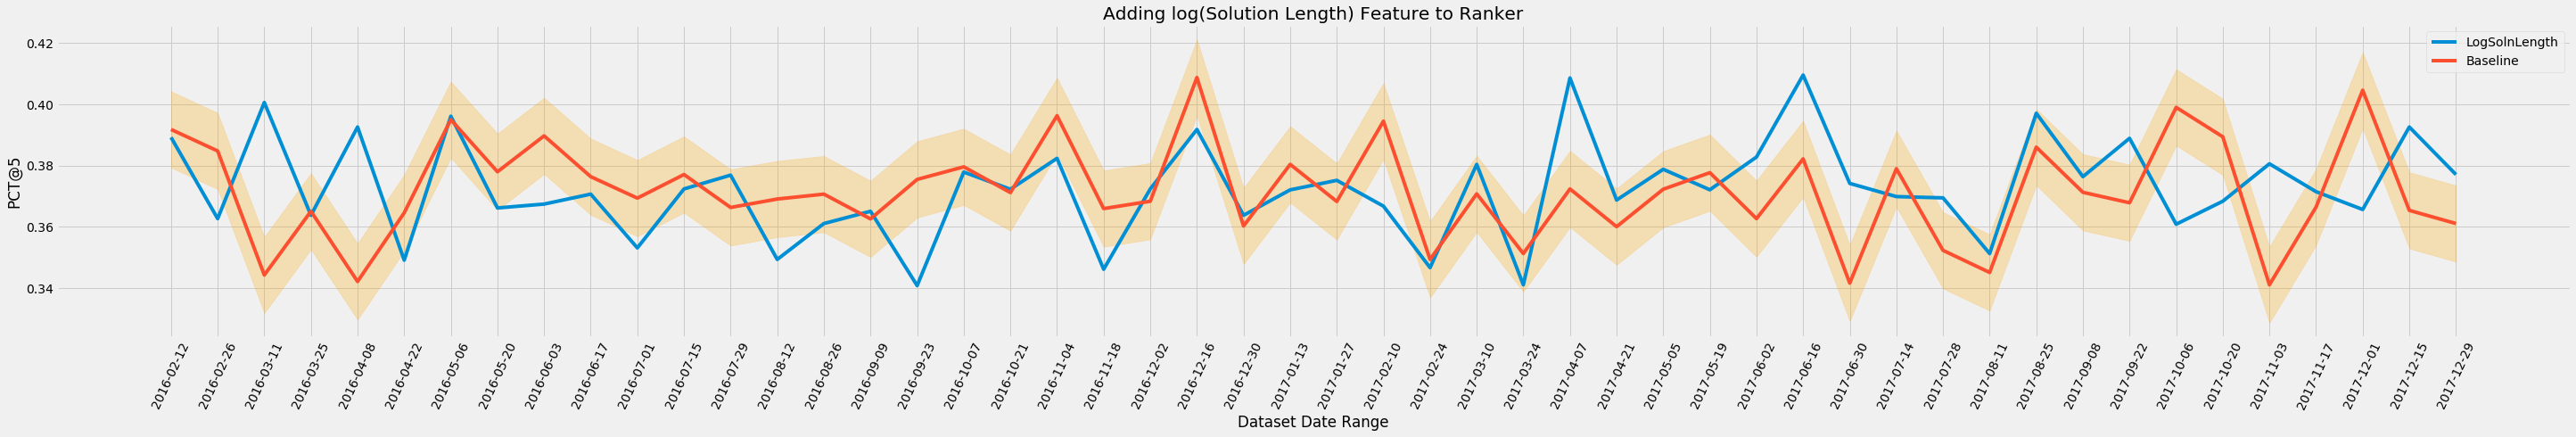

In [270]:
plt.plot(dates, logsolnlength_pct5, label="LogSolnLength")
# plt.plot(dates, solnlength_pct5, label="SolnLength")
plt.plot(dates, baseline_pct5, label="Baseline")
# plt.plot(dates, assigneddomains_pct5, label="AssignedDomains")
plt.ylabel("PCT@5")
plt.xlabel("Dataset Date Range")
plt.title("Adding log(Solution Length) Feature to Ranker")
plt.xticks(fontsize=14, rotation=65)


baseline_error = get_error(baseline_pct5, 1500)
plt.fill_between(range(len(dates)), 
                 [val + baseline_error for val in baseline_pct5], 
                 [val - baseline_error for val in baseline_pct5], color='orange', alpha=.25)
plt.legend()
plt.show()

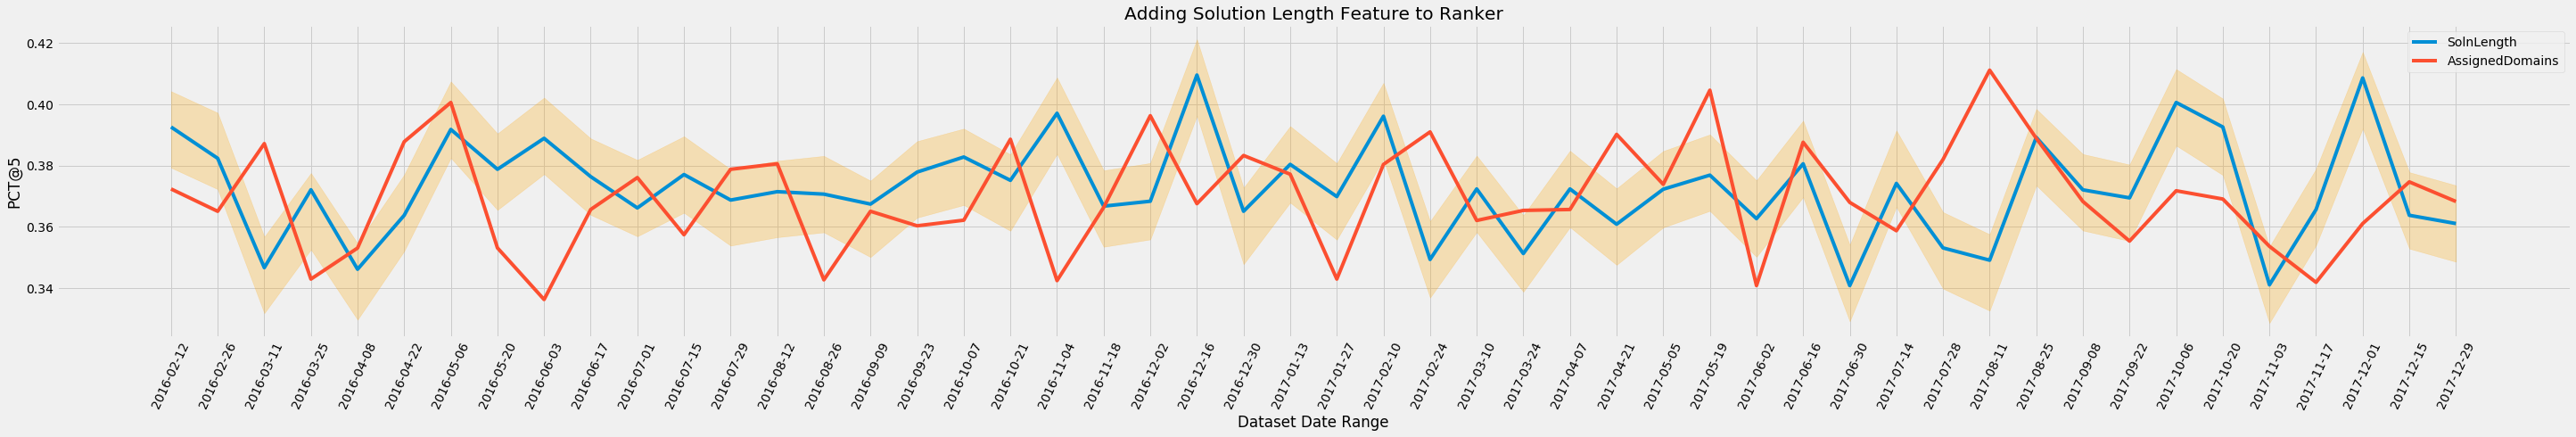

In [271]:
# plt.plot(dates, logsolnlength_pct5, label="LogSolnLength")
plt.plot(dates, solnlength_pct5, label="SolnLength")
# plt.plot(dates, baseline_pct5, label="Baseline")
plt.plot(dates, assigneddomains_pct5, label="AssignedDomains")
plt.ylabel("PCT@5")
plt.xlabel("Dataset Date Range")
plt.title("Adding Solution Length Feature to Ranker")
plt.xticks(fontsize=14, rotation=65)


baseline_error = get_error(baseline_pct5, 1500)
plt.fill_between(range(len(dates)), 
                 [val + baseline_error for val in baseline_pct5], 
                 [val - baseline_error for val in baseline_pct5], color='orange', alpha=.25)
plt.legend()
plt.show()

## Summarizing Statistics
This section will create a DataFrame with a few statistics that will summarize the impact of adding a new feature. They are as follows:

* Average distance to the baseline
    * For each each data point, the signed difference between the baseline PCT@5 and the new feature PCT@5 is computed and then the average of those distances is returned.
* Average Significance of the Differences
    * The difference between the baseline and feature PCT@5 is divided by the maximum standard error across 

In [50]:
import math

import pandas as pd

def avg_dist_to_baseline(baseline, new_feature):
    return np.mean(np.subtract(new_feature, baseline, dtype=float64), dtype=float64)

def standard_error(p_success, n_total):
    return (p_success * (1 - p_success) / n_total)**0.5

def standard_errors(p_successes, n_totals):
    return [standard_error(p_success, n_total) for p_success, n_total in zip(p_successes, n_totals)]

def average_significance_of_difference(p_successes_baseline, 
                                       p_successes_feature,
                                       n_totals):
    max_standard_error = max(max(standard_errors(p_successes_baseline, n_totals)),
                             max(standard_errors(p_successes_feature, n_totals)))
    return avg_dist_to_baseline(p_successes_baseline, p_successes_feature) / max_standard_error

def confidence_interval(average_sigma):
    return math.erf(average_sigma / 2.0**0.5)

def generate_df_row(feature_name, avg_dist, avg_significance, confidence_interval):
    return {"Feature Name": feature_name,
            "Average Distance to Baseline": avg_dist,
            "Average Significance of Differences": avg_significance,
            "Confidence Interval": confidence_interval}

In [106]:
N_TOTALS = [1000] + 49*[1250]

all_pct5s = [linked_cohesion_pct5s, solution_length_pct5s, solution_log_length_pct5s, solution_assigned_domains_pct5s]
feature_names = ["Linked Cohesion", "Solution Length", "log(Solution Length)", "Number of Assigned Domains to Solution"]

df = pd.DataFrame([generate_df_row(feature_name, 
                                   avg_dist_to_baseline(baseline_pct5s, new_feature_pct5),
                                   average_significance_of_difference(baseline_pct5s, new_feature_pct5, N_TOTALS),
                                   confidence_interval(average_significance_of_difference(baseline_pct5s, new_feature_pct5, N_TOTALS)))
                  for new_feature_pct5, feature_name in zip(all_pct5s, feature_names)])
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df

,Feature Name,Average Distance to Baseline,Average Significance of Differences,Confidence Interval
0,Linked Cohesion,-0.001181,-0.077433,-0.061721
1,Solution Length,0.000911,0.059577,0.047507
2,log(Solution Length),0.000911,0.059577,0.047507
3,Number of Assigned Domains to Solution,-0.001970,-0.129370,-0.102935
